In [3]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Model 1: Basic GP

In [4]:
modeWeightsOrig = pd.read_csv(r'Mode_Weight_Full_Cohort.csv',index_col='Mesh_ID')
print(modeWeightsOrig)

               Mode1      Mode2      Mode3      Mode4      Mode5      Mode6  \
Mesh_ID                                                                       
1         -26.526282 -21.987510  45.298672   6.964297   1.264487 -14.710058   
2         -16.902798  23.644504  19.452896 -24.329813 -25.447350  20.415574   
3          14.528402  16.328970  -5.269040  31.653975   7.173021  17.494031   
4         -15.076964  28.889168   8.644859   4.758042   1.301095   5.983310   
5          -3.839848 -47.723637   7.042452  -4.914959  -4.014415  20.366371   
6          18.372208 -13.173184 -10.191443 -24.148353   5.156296  -5.613573   
7         -34.355273 -16.804885  -6.838693 -12.785964   5.546781 -11.206395   
8         -25.433101   7.377060  16.518874  10.553323  20.454561  -3.834116   
11         80.119501   6.505305   4.707190  18.693887 -17.988034  -9.927770   
12         51.114176 -25.099497  -6.603593  -1.858095   2.108524   6.369323   
13          2.227391  21.550335  14.556385 -15.90453

In [5]:
modelOutputOrig = pd.read_csv(r'simulation_output_Full_Cohort.csv',index_col=0)
print(modelOutputOrig)

            EDV_LV  Myo_vol_LV  ESV_LV   SV_LV    V1_LV     EF1_LV  \
Mesh_ID                                                              
1          119.650  163.305835  55.614  64.036   90.248  24.573339   
2          128.603  202.159662  51.027  77.576   98.402  23.483900   
3          152.279  154.973015  65.778  86.501  110.147  27.667636   
4          145.034  199.463111  57.180  87.854  105.630  27.168802   
5          118.599   91.976665  55.855  62.744   94.714  20.139293   
6           85.968  109.660211  40.184  45.784   68.640  20.156337   
7          113.130   94.998853  49.677  63.453   84.963  24.897905   
8          142.547  135.194656  64.998  77.549  107.610  24.509109   
11         140.874  140.723552  65.420  75.454  107.909  23.400344   
12         101.382  101.575101  45.137  56.245   77.413  23.642264   
13         139.551  152.838953  59.194  80.357  103.644  25.730378   
14         176.987  167.319878  79.883  97.104  129.387  26.894631   
15         103.318  

In [6]:
def modeNorm(modeWeightsOrig):
    modeMax=np.max(modeWeightsOrig,axis=0)
    modeMean = np.mean(modeWeightsOrig,axis=0)
    modeStd = np.std(modeWeightsOrig,axis=0)
    #modeMin = np.min(modeWeightsOrig,axis=0)
    modeNorm = (modeWeightsOrig-modeMean)/(modeStd)
    #modeNorm = modeWeightsOrig/modeMax
    modeWeights=modeNorm
    return modeWeights

In [7]:
modeWeights = modeNorm(modeWeightsOrig)

In [8]:
def outputNorm(modelOutputOrig):
    outMax = np.max(modelOutputOrig,axis=0)
    outMean = np.mean(modelOutputOrig,axis=0)
    outStd = np.std(modelOutputOrig,axis=0)
    modelOutput = (modelOutputOrig-outMean)/outStd.T
    return modelOutput

In [9]:
modelOutput=outputNorm(modelOutputOrig)

In [10]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ARD=True))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [11]:
class ZeroMeanGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ZeroMeanGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ARD=True))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [12]:
def GPEnsemble(modeWeights,modelOutput,zeroMean=False):
    models = []
    likelihoods = []
    MSE = []
    nMod = modelOutput.shape[1]
    for i in range(nMod):
        print(i)
        likelihoods.append(gpytorch.likelihoods.GaussianLikelihood())
        if zeroMean==False:
            models.append(ExactGPModel(torch.tensor(modeWeights.values), torch.tensor(modelOutput.iloc[:,i].values).squeeze(), likelihoods[i]))
        else:
            models.append(ZeroMeanGPModel(torch.tensor(modeWeights.values), torch.tensor(modelOutput.iloc[:,i].values).squeeze(), likelihoods[i]))
        smoke_test = ('CI' in os.environ)
        training_iter = 2 if smoke_test else 100


        # Find optimal model hyperparameters
        models[i].train()
        likelihoods[i].train()
        X=torch.tensor(modeWeights.values)
        Y=torch.tensor(modelOutput.iloc[:,i].values).squeeze()

        # Use the adam optimizer
        optimizer = torch.optim.Adam(models[i] .parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihoods[i], models[i] )


        for j in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = models[i](X)
            # Calc loss and backprop gradients
            loss = -mll(output, Y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            #    j + 1, training_iter, loss.item(),
            #    models[i].covar_module.base_kernel.lengthscale.item(),
            #    models[i].likelihood.noise.item()
            #))
            optimizer.step()
        models[i].eval()
        MSE.append(((models[i](torch.tensor([modeWeights.values])).mean-torch.tensor(modelOutput.iloc[:,i]))**2).mean());
    return models, likelihoods, MSE

In [13]:
models, likelihoods, MSE = GPEnsemble(modeWeights,modelOutput)

0


C:\Users\chris\AppData\Local\Temp\ipykernel_7472\1632156881.py:45: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  MSE.append(((models[i](torch.tensor([modeWeights.values])).mean-torch.tensor(modelOutput.iloc[:,i]))**2).mean());


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [14]:
MSE

[tensor(0.0015, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0083, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0009, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0022, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0024, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0235, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.1234, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0750, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0582, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.3528, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.0989, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2584, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2141, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.1831, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(0.2093, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor(2.2179e-05, dtype=torch.float64, grad_fn=<MeanB

In [41]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': 9,
    'names': ['Mode 1', 'Mode 2', 'Mode 3', 'Mode 4','Mode 5','Mode 6', 'Mode 7', 'Mode 8', 'Mode 9'],
    'bounds': [[-1, 1],
               [-1, 1],
               [-1, 1],
               [-1, 1],
               [-1, 1],
               [-1, 1],
               [-1, 1],
               [-1, 1],
               [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

Ymean = []
# Run model (example)
outMean = np.mean(modelOutputOrig,axis=0)
outStd = np.std(modelOutputOrig,axis=0)
nMod = modelOutput.shape[1]
for j in range(nMod):
    Ymean.append(np.zeros([param_values.shape[0]]))
    Ymean[j] = outStd[j]*models[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])).mean+outMean[j]

C:\Users\chris\AppData\Local\Temp\ipykernel_7472\3847717886.py:23: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [42]:
Si = []
nMod = modelOutput.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[i].detach().numpy().squeeze(), print_to_console=True))

              ST   ST_conf
Mode 1  0.024241  0.002251
Mode 2  0.357560  0.029024
Mode 3  0.202023  0.018201
Mode 4  0.285131  0.022398
Mode 5  0.011106  0.000996
Mode 6  0.000135  0.000016
Mode 7  0.006214  0.000550
Mode 8  0.001168  0.000106
Mode 9  0.112231  0.009220
              S1   S1_conf
Mode 1  0.024381  0.015318
Mode 2  0.357816  0.048977
Mode 3  0.202509  0.033229
Mode 4  0.285361  0.037430
Mode 5  0.010951  0.008520
Mode 6  0.000014  0.001008
Mode 7  0.006275  0.006749
Mode 8  0.001231  0.003390
Mode 9  0.111709  0.027634
                        S2   S2_conf
(Mode 1, Mode 2) -0.000271  0.023025
(Mode 1, Mode 3) -0.000083  0.023311
(Mode 1, Mode 4) -0.000147  0.024581
(Mode 1, Mode 5) -0.000075  0.020876
(Mode 1, Mode 6) -0.000053  0.020617
(Mode 1, Mode 7) -0.000138  0.020630
(Mode 1, Mode 8) -0.000086  0.020608
(Mode 1, Mode 9) -0.000062  0.021916
(Mode 2, Mode 3) -0.000217  0.075242
(Mode 2, Mode 4) -0.000378  0.083111
(Mode 2, Mode 5) -0.000112  0.067823
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.445057  0.036789
Mode 2  0.215823  0.019670
Mode 3  0.007300  0.000684
Mode 4  0.090602  0.007969
Mode 5  0.015208  0.001388
Mode 6  0.018004  0.001781
Mode 7  0.003986  0.000469
Mode 8  0.086267  0.009185
Mode 9  0.118243  0.011239
              S1   S1_conf
Mode 1  0.445583  0.047082
Mode 2  0.216549  0.037317
Mode 3  0.006360  0.007472
Mode 4  0.089862  0.022702
Mode 5  0.014095  0.011568
Mode 6  0.017713  0.011332
Mode 7  0.004552  0.004874
Mode 8  0.086481  0.026557
Mode 9  0.118957  0.030877
                        S2   S2_conf
(Mode 1, Mode 2) -0.001187  0.076999
(Mode 1, Mode 3)  0.000153  0.066009
(Mode 1, Mode 4)  0.000074  0.063709
(Mode 1, Mode 5) -0.000005  0.065846
(Mode 1, Mode 6)  0.000204  0.067371
(Mode 1, Mode 7) -0.000248  0.066390
(Mode 1, Mode 8) -0.000060  0.069617
(Mode 1, Mode 9) -0.000259  0.070610
(Mode 2, Mode 3) -0.000568  0.055642
(Mode 2, Mode 4) -0.000947  0.057056
(Mode 2, Mode 5) -0.000365  0.057093
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.002260  0.000214
Mode 2  0.132524  0.012808
Mode 3  0.394089  0.031027
Mode 4  0.123418  0.011777
Mode 5  0.111972  0.010098
Mode 6  0.002512  0.000287
Mode 7  0.017929  0.001837
Mode 8  0.000581  0.000057
Mode 9  0.215297  0.019332
              S1   S1_conf
Mode 1  0.002150  0.005363
Mode 2  0.132547  0.027498
Mode 3  0.396158  0.044410
Mode 4  0.123677  0.029822
Mode 5  0.111945  0.029983
Mode 6  0.002152  0.004013
Mode 7  0.018230  0.011014
Mode 8  0.000514  0.002085
Mode 9  0.211990  0.033892
                        S2   S2_conf
(Mode 1, Mode 2)  0.000118  0.007819
(Mode 1, Mode 3)  0.000128  0.008495
(Mode 1, Mode 4)  0.000110  0.008171
(Mode 1, Mode 5)  0.000064  0.007657
(Mode 1, Mode 6)  0.000030  0.007604
(Mode 1, Mode 7)  0.000028  0.007526
(Mode 1, Mode 8)  0.000039  0.007535
(Mode 1, Mode 9) -0.000014  0.008324
(Mode 2, Mode 3) -0.000153  0.046720
(Mode 2, Mode 4) -0.000078  0.044851
(Mode 2, Mode 5) -0.000378  0.039874
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.048906  0.004025
Mode 2  0.583989  0.046422
Mode 3  0.211322  0.018038
Mode 4  0.142555  0.012838
Mode 5  0.004072  0.000346
Mode 6  0.004657  0.000680
Mode 7  0.004932  0.000482
Mode 8  0.000102  0.000013
Mode 9  0.006154  0.000925
              S1   S1_conf
Mode 1  0.048252  0.021071
Mode 2  0.583486  0.055514
Mode 3  0.198209  0.035093
Mode 4  0.141756  0.031106
Mode 5  0.003759  0.005660
Mode 6  0.003202  0.005329
Mode 7  0.004883  0.005616
Mode 8  0.000069  0.000790
Mode 9  0.008939  0.006337
                        S2   S2_conf
(Mode 1, Mode 2) -0.000441  0.039998
(Mode 1, Mode 3) -0.000011  0.032000
(Mode 1, Mode 4) -0.000091  0.034014
(Mode 1, Mode 5) -0.000023  0.031122
(Mode 1, Mode 6)  0.000189  0.031117
(Mode 1, Mode 7) -0.000081  0.031096
(Mode 1, Mode 8)  0.000006  0.031108
(Mode 1, Mode 9)  0.000488  0.031206
(Mode 2, Mode 3)  0.000538  0.097951
(Mode 2, Mode 4) -0.001015  0.092897
(Mode 2, Mode 5) -0.000269  0.082765
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.059383  0.005446
Mode 2  0.573440  0.044387
Mode 3  0.178086  0.017327
Mode 4  0.180025  0.016402
Mode 5  0.000038  0.000005
Mode 6  0.002558  0.000405
Mode 7  0.000332  0.000039
Mode 8  0.005108  0.000476
Mode 9  0.005364  0.000755
              S1   S1_conf
Mode 1  0.058908  0.019059
Mode 2  0.573328  0.062317
Mode 3  0.168233  0.032989
Mode 4  0.179560  0.039115
Mode 5 -0.000075  0.000533
Mode 6  0.001675  0.004576
Mode 7  0.000314  0.001496
Mode 8  0.005055  0.006489
Mode 9  0.008166  0.006020
                        S2   S2_conf
(Mode 1, Mode 2) -0.000381  0.031541
(Mode 1, Mode 3)  0.000125  0.029338
(Mode 1, Mode 4)  0.000030  0.029705
(Mode 1, Mode 5)  0.000134  0.026738
(Mode 1, Mode 6)  0.000376  0.026544
(Mode 1, Mode 7)  0.000034  0.026768
(Mode 1, Mode 8)  0.000193  0.026640
(Mode 1, Mode 9)  0.000462  0.027203
(Mode 2, Mode 3)  0.000542  0.091619
(Mode 2, Mode 4) -0.000927  0.098271
(Mode 2, Mode 5) -0.000273  0.085905
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.027315  0.002991
Mode 2  0.075344  0.008038
Mode 3  0.090138  0.009142
Mode 4  0.005712  0.000897
Mode 5  0.391141  0.035636
Mode 6  0.008071  0.001506
Mode 7  0.400474  0.043307
Mode 8  0.016303  0.001545
Mode 9  0.014768  0.001706
              S1   S1_conf
Mode 1  0.017760  0.014463
Mode 2  0.067133  0.024175
Mode 3  0.081193  0.026498
Mode 4 -0.000578  0.005679
Mode 5  0.383557  0.052525
Mode 6  0.003477  0.007012
Mode 7  0.390006  0.054342
Mode 8  0.009617  0.009594
Mode 9  0.007485  0.010506
                        S2   S2_conf
(Mode 1, Mode 2)  0.004446  0.020098
(Mode 1, Mode 3)  0.003390  0.021567
(Mode 1, Mode 4)  0.004372  0.020102
(Mode 1, Mode 5)  0.006881  0.023291
(Mode 1, Mode 6)  0.003840  0.020012
(Mode 1, Mode 7)  0.005678  0.022662
(Mode 1, Mode 8)  0.003966  0.019809
(Mode 1, Mode 9)  0.004211  0.019870
(Mode 2, Mode 3)  0.000721  0.036167
(Mode 2, Mode 4)  0.001015  0.035086
(Mode 2, Mode 5)  0.000583  0.039534
(Mode 2, Mode 6)

# Model 2: Linear regression + Zero Mean GP

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# generate random data-set

# sckit-learn implementation

# Model initialization
regression_model = LinearRegression()
# Fit the data(train the model)
regression_model.fit(modeWeights, modelOutput)
# Predict
y_predicted = regression_model.predict(modeWeights)

# model evaluation
rmse = mean_squared_error(modelOutput, y_predicted)
r2 = r2_score(modelOutput, y_predicted)

# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)


Slope: [[-1.54021589e-01  5.26176805e-01  4.17042799e-01  5.39143927e-01
  -1.09621406e-01  1.52498636e-02 -5.76630938e-02 -4.77345391e-02
  -3.48296527e-01  3.61466431e-02 -2.43841516e-02  3.96034226e-02
  -5.36768588e-02 -1.26329919e-01 -6.94980233e-02  3.14869257e-03
   1.19471093e-02 -6.49790700e-02]
 [-9.07731209e-02  8.00939349e-01  3.83192485e-01  5.35958184e-02
  -1.01739602e-01  8.98668944e-02 -2.47704147e-01  5.01152561e-02
   2.21716228e-01  1.06651020e-01  1.85600746e-05  3.69214364e-02
  -9.43340531e-02  3.05087488e-02  1.70157534e-02  3.68747010e-03
  -9.13405184e-02 -6.95339609e-04]
 [-8.31191016e-02  3.36359536e-01  4.20392750e-01  6.11489099e-01
  -1.25603466e-01 -4.53733161e-02 -5.62885097e-03 -1.15411668e-01
  -4.38773588e-01  1.27615955e-03 -4.56286778e-02  5.15934663e-02
  -6.44933969e-02 -1.00746004e-01 -6.66996083e-02  4.85151626e-02
   1.58931055e-02 -1.14531945e-01]
 [-2.03469900e-01  6.50605738e-01  3.85065482e-01  4.40049221e-01
  -8.83924406e-02  6.56633485e

In [18]:
modelOutputAdjusted = modelOutput - y_predicted

In [19]:
modelsZM, likelihoodsZM,MSEZM = GPEnsemble(modeWeights,modelOutputAdjusted,zeroMean=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [20]:
YmeanSens=[]
nMod = modelOutput.shape[1]
y_predictedSens = regression_model.predict(np.hstack((param_values,np.zeros((param_values.shape[0],9)))))
for j in range(nMod):
    YmeanSens.append(np.zeros([param_values.shape[0]]))
    YmeanSens[j] = torch.tensor([y_predictedSens[:,j]])+modelsZM[j](torch.tensor([np.hstack((param_values,np.zeros((param_values.shape[0],9))))])).mean

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [21]:
regression_model.predict(np.hstack((param_values,np.zeros((param_values.shape[0],9))))).shape

C:\Users\chris\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


(20480, 29)

In [22]:
SiZM = []
nMod = modelOutput.shape[1]
for i in range(nMod):
    SiZM.append(sobol.analyze(problem, YmeanSens[i].detach().numpy().squeeze(), print_to_console=True))

              ST   ST_conf
Mode 1  0.025809  0.002333
Mode 2  0.315779  0.027911
Mode 3  0.197114  0.015410
Mode 4  0.312285  0.025736
Mode 5  0.012720  0.001054
Mode 6  0.000135  0.000011
Mode 7  0.004515  0.000414
Mode 8  0.002051  0.000182
Mode 9  0.129533  0.009771
              S1   S1_conf
Mode 1  0.025871  0.014694
Mode 2  0.315865  0.040054
Mode 3  0.197141  0.037098
Mode 4  0.312381  0.045404
Mode 5  0.012687  0.010801
Mode 6  0.000077  0.000940
Mode 7  0.004531  0.006193
Mode 8  0.002066  0.004054
Mode 9  0.129458  0.030600
                        S2   S2_conf
(Mode 1, Mode 2) -0.000073  0.022314
(Mode 1, Mode 3) -0.000043  0.020097
(Mode 1, Mode 4) -0.000056  0.021802
(Mode 1, Mode 5) -0.000036  0.018294
(Mode 1, Mode 6) -0.000025  0.018147
(Mode 1, Mode 7) -0.000067  0.018122
(Mode 1, Mode 8) -0.000039  0.018044
(Mode 1, Mode 9) -0.000037  0.019894
(Mode 2, Mode 3) -0.000035  0.065260
(Mode 2, Mode 4) -0.000004  0.066586
(Mode 2, Mode 5)  0.000020  0.058888
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.430246  0.035997
Mode 2  0.284097  0.024562
Mode 3  0.010336  0.001017
Mode 4  0.105318  0.009641
Mode 5  0.013855  0.001459
Mode 6  0.018130  0.001636
Mode 7  0.002172  0.000240
Mode 8  0.040603  0.003408
Mode 9  0.096342  0.008487
              S1   S1_conf
Mode 1  0.431309  0.047987
Mode 2  0.283884  0.044355
Mode 3  0.009073  0.007914
Mode 4  0.104226  0.025211
Mode 5  0.014489  0.008683
Mode 6  0.020169  0.011274
Mode 7  0.002362  0.003752
Mode 8  0.039886  0.017132
Mode 9  0.095800  0.023555
                        S2   S2_conf
(Mode 1, Mode 2) -0.001461  0.078907
(Mode 1, Mode 3) -0.002042  0.067457
(Mode 1, Mode 4) -0.001736  0.071632
(Mode 1, Mode 5) -0.001801  0.069873
(Mode 1, Mode 6) -0.002293  0.069519
(Mode 1, Mode 7) -0.002165  0.068559
(Mode 1, Mode 8) -0.001627  0.071956
(Mode 1, Mode 9) -0.002125  0.065608
(Mode 2, Mode 3)  0.000711  0.060626
(Mode 2, Mode 4)  0.000445  0.063834
(Mode 2, Mode 5)  0.000308  0.061856
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.000748  0.000062
Mode 2  0.108238  0.009430
Mode 3  0.351127  0.025214
Mode 4  0.093791  0.007742
Mode 5  0.104785  0.008137
Mode 6  0.003631  0.000327
Mode 7  0.012579  0.001195
Mode 8  0.000076  0.000006
Mode 9  0.325032  0.023746
              S1   S1_conf
Mode 1  0.000752  0.002733
Mode 2  0.108261  0.025364
Mode 3  0.351192  0.044664
Mode 4  0.093829  0.022075
Mode 5  0.104791  0.026313
Mode 6  0.003536  0.005008
Mode 7  0.012632  0.009420
Mode 8  0.000078  0.000822
Mode 9  0.325182  0.038606
                        S2   S2_conf
(Mode 1, Mode 2) -0.000009  0.003902
(Mode 1, Mode 3) -0.000002  0.003901
(Mode 1, Mode 4) -0.000004  0.003890
(Mode 1, Mode 5) -0.000006  0.003686
(Mode 1, Mode 6) -0.000006  0.003579
(Mode 1, Mode 7) -0.000015  0.003552
(Mode 1, Mode 8) -0.000006  0.003584
(Mode 1, Mode 9) -0.000004  0.004754
(Mode 2, Mode 3) -0.000037  0.049704
(Mode 2, Mode 4)  0.000004  0.040929
(Mode 2, Mode 5)  0.000005  0.040191
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.055193  0.004461
Mode 2  0.551229  0.043739
Mode 3  0.234234  0.018301
Mode 4  0.142693  0.011943
Mode 5  0.003296  0.000296
Mode 6  0.004713  0.000428
Mode 7  0.005761  0.000495
Mode 8  0.000115  0.000015
Mode 9  0.004313  0.000594
              S1   S1_conf
Mode 1  0.054810  0.020104
Mode 2  0.551747  0.054427
Mode 3  0.230694  0.039689
Mode 4  0.142972  0.032413
Mode 5  0.003258  0.005043
Mode 6  0.004864  0.005953
Mode 7  0.006160  0.006763
Mode 8  0.000157  0.000923
Mode 9  0.006468  0.006649
                        S2   S2_conf
(Mode 1, Mode 2) -0.000129  0.034974
(Mode 1, Mode 3)  0.000030  0.032511
(Mode 1, Mode 4) -0.000215  0.029760
(Mode 1, Mode 5)  0.000085  0.028013
(Mode 1, Mode 6)  0.000318  0.028074
(Mode 1, Mode 7)  0.000051  0.027804
(Mode 1, Mode 8)  0.000178  0.027992
(Mode 1, Mode 9)  0.000435  0.028304
(Mode 2, Mode 3) -0.000724  0.087763
(Mode 2, Mode 4) -0.000061  0.092153
(Mode 2, Mode 5) -0.000427  0.080875
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.071996  0.006959
Mode 2  0.565967  0.050934
Mode 3  0.179684  0.017029
Mode 4  0.168236  0.015096
Mode 5  0.002194  0.000193
Mode 6  0.004389  0.000404
Mode 7  0.002584  0.000283
Mode 8  0.000157  0.000022
Mode 9  0.006089  0.000643
              S1   S1_conf
Mode 1  0.071672  0.023125
Mode 2  0.566739  0.053604
Mode 3  0.178729  0.033414
Mode 4  0.169192  0.038430
Mode 5  0.002166  0.003675
Mode 6  0.004602  0.005795
Mode 7  0.003270  0.004018
Mode 8  0.000209  0.001050
Mode 9  0.006576  0.006213
                        S2   S2_conf
(Mode 1, Mode 2)  0.000285  0.043644
(Mode 1, Mode 3)  0.000751  0.034051
(Mode 1, Mode 4)  0.000170  0.031543
(Mode 1, Mode 5)  0.000811  0.031779
(Mode 1, Mode 6)  0.000955  0.032076
(Mode 1, Mode 7)  0.000781  0.031774
(Mode 1, Mode 8)  0.000845  0.031797
(Mode 1, Mode 9)  0.000984  0.032326
(Mode 2, Mode 3) -0.001408  0.092255
(Mode 2, Mode 4) -0.000233  0.097954
(Mode 2, Mode 5) -0.001057  0.082146
(Mode 2, Mode 6)

              ST   ST_conf
Mode 1  0.060273  0.005037
Mode 2  0.178250  0.014236
Mode 3  0.013891  0.001417
Mode 4  0.002448  0.000228
Mode 5  0.278652  0.025843
Mode 6  0.015832  0.001293
Mode 7  0.004367  0.000701
Mode 8  0.012119  0.000938
Mode 9  0.436949  0.035004
              S1   S1_conf
Mode 1  0.058926  0.021331
Mode 2  0.177921  0.030023
Mode 3  0.013199  0.010667
Mode 4  0.000079  0.004630
Mode 5  0.274309  0.043000
Mode 6  0.016451  0.010292
Mode 7  0.004664  0.005081
Mode 8  0.011499  0.010362
Mode 9  0.437795  0.052806
                        S2   S2_conf
(Mode 1, Mode 2)  0.000321  0.030743
(Mode 1, Mode 3)  0.000503  0.031859
(Mode 1, Mode 4)  0.001266  0.031333
(Mode 1, Mode 5)  0.001464  0.035213
(Mode 1, Mode 6)  0.001051  0.031179
(Mode 1, Mode 7)  0.000891  0.031159
(Mode 1, Mode 8)  0.001245  0.032016
(Mode 1, Mode 9)  0.001186  0.035922
(Mode 2, Mode 3) -0.001926  0.049626
(Mode 2, Mode 4) -0.000858  0.049623
(Mode 2, Mode 5) -0.000891  0.049804
(Mode 2, Mode 6)

In [23]:
SiZM_first=np.zeros((9,nMod))
SiZM_total=np.zeros((9,nMod))
Si_first=np.zeros((9,nMod))
Si_total=np.zeros((9,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = SiZM[i].to_df()
    SiZM_first[:,i] =  first_Si.iloc[:,0]
    SiZM_total[:,i] =  total_Si.iloc[:,0]
    
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]

## Linear Regression + GP

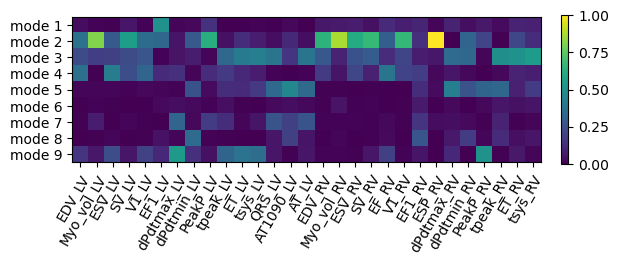

In [24]:
modes = ["mode 1", "mode 2", "mode 3", "mode 4",
              "mode 5", "mode 6", "mode 7", "mode 8", "mode 9"]
outputs = list(modelOutput.columns)

fig, ax = plt.subplots()
im = ax.imshow(SiZM_first/np.max(SiZM_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [30]:
SiZM_first[:,2]

array([0.00428823, 0.24208414, 0.16032135, 0.36073874, 0.01556208,
       0.00276331, 0.00179756, 0.01136649, 0.20153374])

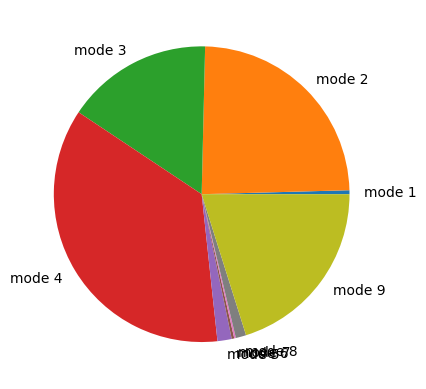

In [37]:
fig, ax = plt.subplots()
ax.pie(SiZM_first[:,2]/np.max(SiZM_first[:,2]), labels=modes);


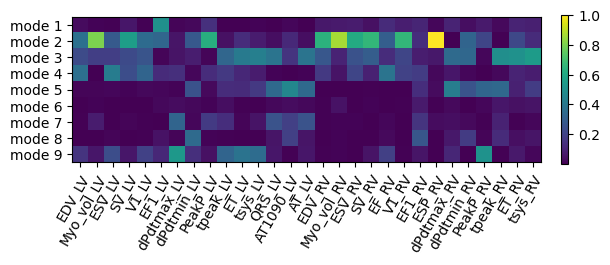

In [26]:
fig, ax = plt.subplots()
im = ax.imshow(SiZM_total/np.max(SiZM_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");
plt.colorbar(im,fraction=0.015, pad=0.04)

## Basic GP

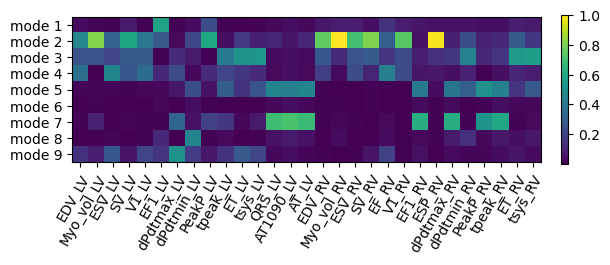

In [43]:
fig, ax = plt.subplots()
im = ax.imshow(Si_total/np.max(Si_total))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

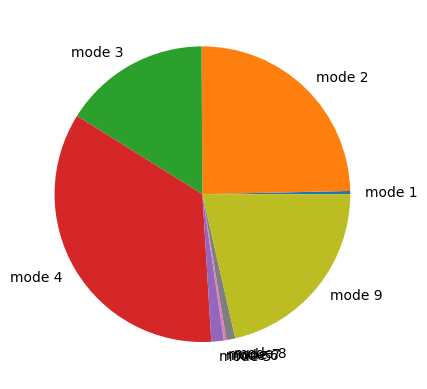

In [44]:
fig, ax = plt.subplots()
ax.pie(Si_first[:,2]/np.max(Si_first[:,2]), labels=modes);


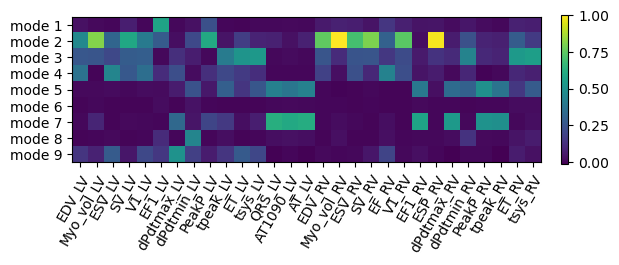

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(Si_first/np.max(Si_first))

ax.set_xticks(np.arange(len(outputs)), labels=outputs)
ax.set_yticks(np.arange(len(modes)), labels=modes)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

# Leave one out MSE

In [103]:
import random

In [104]:
def standardise(data,mean,std):
    dataStandard = (data-mean)/std.T
    return dataStandard

In [136]:
def EnsembleMSE(models,modelInput,modelOutput):
    MSE = np.zeros(outputTestNorm.shape[1])
    nMod = modelOutput.shape[1]
    for i in range(nMod):
        models[i].eval()
        
        MSE[i] = (((models[i](torch.tensor([modelInput.values])).mean-torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [178]:
def LREnsembleMSE(GPmodels,LRModel,modelInput,modelOutput):
    MSE = np.zeros(outputTestNorm.shape[1])
    nMod = modelOutput.shape[1]
    y_predicted = regression_model.predict(modelInput)
    for i in range(nMod):
        GPmodels[i].eval()
        
        MSE[i] = (((torch.tensor(y_predicted[:,i])+GPmodels[i](torch.tensor([modelInput.values])).mean-torch.tensor(modelOutput.iloc[:,i].values))**2).mean());
    return MSE

In [179]:
modeWeightsOrig.shape

(51, 18)

In [180]:
GP_MSE = np.zeros(outputTestNorm.shape[1])
LRGP_MSE = np.zeros(outputTestNorm.shape[1])

for i in range(modeWeightsOrig.shape[0]):

    testIndices = [i]
    inputTest = modeWeightsOrig.iloc[testIndices,:]
    inputTrain = modeWeightsOrig[~modeWeightsOrig.index.isin(testIndices)]
    outputTest = modelOutputOrig.iloc[testIndices,:]
    outputTrain = modelOutputOrig.iloc[~modelOutputOrig.index.isin(testIndices)]
    
    outputTrainMean = np.mean(outputTrain,axis=0)
    outputTrainStd = np.std(outputTrain,axis=0)

    inputTrainMean = np.mean(inputTrain,axis=0)
    inputTrainStd = np.std(inputTrain,axis=0)
    
    inputTestNorm = standardise(inputTest,inputTrainMean,inputTrainStd)
    inputTrainNorm = standardise(inputTrain,inputTrainMean,inputTrainStd)
    outputTestNorm = standardise(outputTest,outputTrainMean,outputTrainStd)
    outputTrainNorm = standardise(outputTrain,outputTrainMean,outputTrainStd)
    
    models, likelihoods, MSE = GPEnsemble(inputTrainNorm,outputTrainNorm)
    
    GP_MSE+= EnsembleMSE(models,inputTestNorm,outputTestNorm)/modeWeightsOrig.shape[0]
    
    regression_model = LinearRegression()
    # Fit the data(train the model)
    regression_model.fit(inputTrainNorm, outputTrainNorm)
    # Predict
    y_predicted = regression_model.predict(inputTrainNorm)
    modelOutputAdjusted = outputTrainNorm - y_predicted
    modelsZM, likelihoodsZM,MSEZM = GPEnsemble(inputTrainNorm,modelOutputAdjusted,zeroMean=True)
    LRGP_MSE+=LREnsembleMSE(modelsZM,regression_model,inputTestNorm,outputTestNorm)/modeWeightsOrig.shape[0]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28

In [181]:
GP_MSE

array([1.46977260e-03, 8.26116679e-03, 8.92871296e-04, 2.16495750e-03,
       2.38546502e-03, 2.34688404e-02, 1.23441489e-01, 7.50490753e-02,
       5.81696329e-02, 3.52786647e-01, 9.88658910e-02, 2.58355764e-01,
       2.14086691e-01, 1.83109972e-01, 2.09261251e-01, 2.21788304e-05,
       8.87228024e-02, 5.52223598e-05, 2.55793411e-05, 5.96548046e-04,
       6.30211761e-03, 3.29956517e-01, 1.76348454e-02, 7.10570656e-02,
       1.36430680e-01, 1.34162964e-01, 1.47366153e-01, 1.40131051e-01,
       2.73005454e-01])

In [182]:
dataset = pd.DataFrame({'GP MSE': GP_MSE, 'LRGP MSE': LRGP_MSE}, columns=['GP MSE', 'LRGP MSE'])
dataset.index = list(modelOutput.columns)

In [183]:
dataset

,GP MSE,LRGP MSE
EDV_LV,0.001470,0.005311
Myo_vol_LV,0.008261,0.019893
ESV_LV,0.000893,0.000682
SV_LV,0.002165,0.001529
V1_LV,0.002385,0.002598
EF1_LV,0.023469,0.003324
dPdtmax_LV,0.123441,0.086199
dPdtmin_LV,0.075049,0.089633
PeakP_LV,0.058170,0.077303
tpeak_LV,0.352787,0.135879
